In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

import cartopy.crs as ccrs
from cmocean import cm

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
client

Client Scheduler: tcp://10.148.0.76:8786 Dashboard: http://10.148.0.76:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB


# Read Eta nc_dataset

_____


In [4]:
data_dir = '/home1/scratch/xyu/mit_nc_t/'
filenames = sorted(glob(data_dir+'SSS_*.nc'))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[0:500]
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')


Number of files available: 100
Number of files processed: 100
CPU times: user 568 ms, sys: 420 ms, total: 988 ms
Wall time: 1.16 s


In [5]:
grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=True)
ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds['SSS'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['SSS'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 100)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG      

# Make a snapshot for each face

____


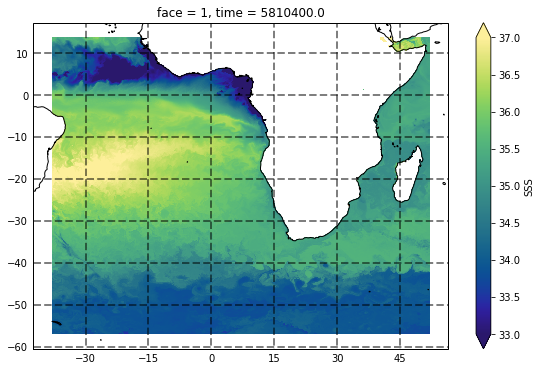

In [12]:
eta = ds['SSS'].isel(face=1, time=30)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

#ax.set_title('a sine wave')
#ax.set_xlabel('Lon')
#ax.set_ylabel('Lat')

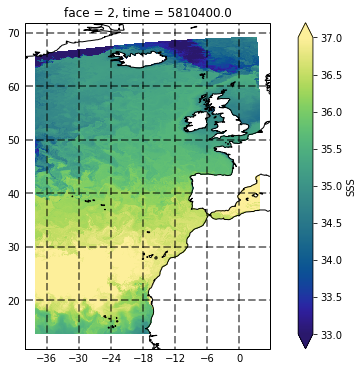

In [14]:
eta = ds['SSS'].isel(face=2, time=30, i=slice(0,2000), j=slice(0,4000)) ###############

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')


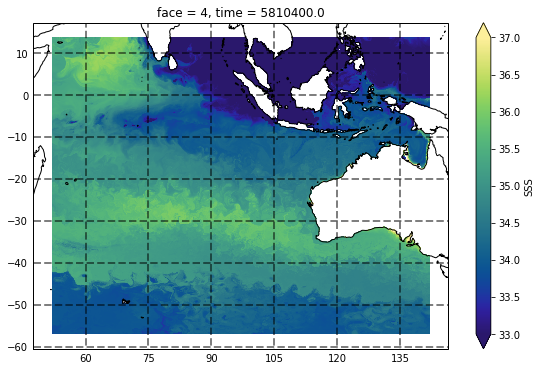

In [16]:
eta = ds['SSS'].isel(face=4, time=30)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')


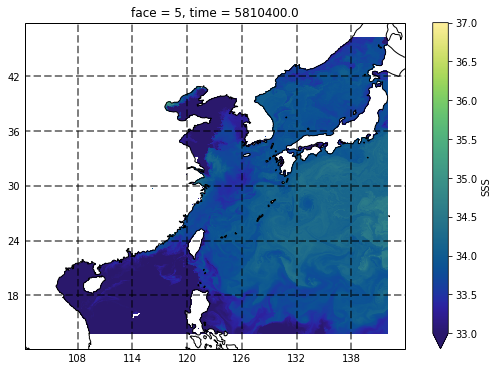

In [6]:
eta = ds['SSS'].isel(face=5, time=30, i=slice(2500,4320), j=slice(0,2000))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')


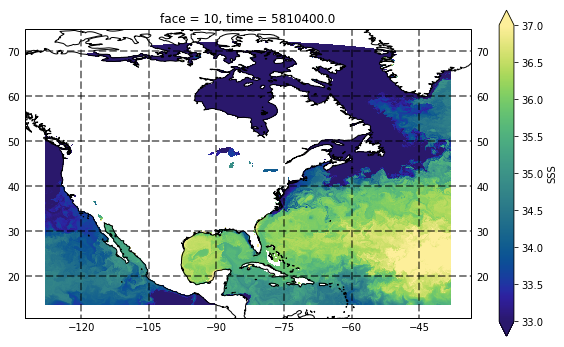

In [7]:
eta = ds['SSS'].isel(face=10, time=30)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
ax.coastlines(resolution='50m', color='k')



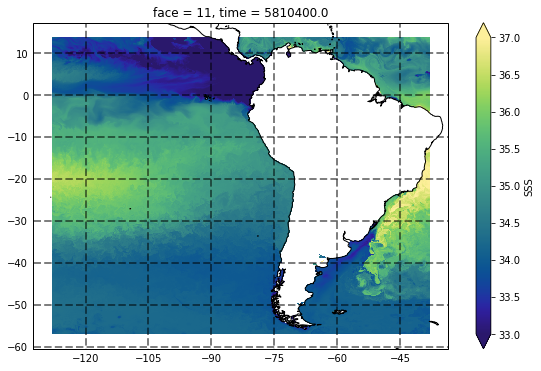

In [8]:
eta = ds['SSS'].isel(face=11, time=30)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=33, vmax=37, cmap = cm.haline)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')


# Make movies

____


## face 1


In [7]:
## Southen Africa ##

face = 1
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU']

    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(1000, 2500)


In [8]:
%time results = compute(*values, get=client.get)

CPU times: user 5.48 s, sys: 336 ms, total: 5.82 s
Wall time: 15min 45s


# face 2

In [9]:
#### Western EU ####

face = 2
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU'].isel(i=slice(0,2000), j=slice(0,4000))

    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(1000, 2500)


In [10]:
%time results = compute(*values, get=client.get)

CPU times: user 4.62 s, sys: 244 ms, total: 4.87 s
Wall time: 8min 5s


# face 4

In [11]:
## Western Australia

face = 4
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)
def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU']

    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home1/datawork/xyu/mit/figs/
range(1000, 2500)


In [ ]:
%time results = compute(*values, get=client.get)

# face 5

In [ ]:
#### China ####

face = 5
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)
def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU'].isel(i=slice(2500,4320), j=slice(0,2000))

    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

In [ ]:
%time results = compute(*values, get=client.get)

# face 10

In [ ]:
# USA #

face = 10
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU']

    
    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

In [ ]:
%time results = compute(*values, get=client.get)

# face 11

In [ ]:
# South America #

face = 11
vmin, vmax = -1., 1.

#delete all figures beforehand
figdir = datawork+'/mit/figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):    
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['SSU']

    
    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_SSU_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'SSU %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(eta.mean().values)
    else:
        m = -1.

I = range(len(ds['time']))
#I = range(1000,2500)
print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

In [ ]:
%time results = compute(*values, get=client.get)

In [16]:
client.restart()

Client Scheduler: tcp://10.148.0.76:8786 Dashboard: http://10.148.0.76:8787/status,Cluster Workers: 20 Cores: 280 Memory: 2000.00 GB
